<a href="https://colab.research.google.com/github/KeremAydin98/spot-the-sun-schwabe/blob/main/Predicting_Sunspot_numpy_indexing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv 

--2022-05-19 07:34:25--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 2607:f8b0:4023:c03::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2022-05-19 07:34:25 (62.7 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



In [ ]:
import pandas as pd

df = pd.read_csv("Sunspots.csv",parse_dates=["Date"],index_col=["Date"]).drop("Unnamed: 0",axis=1)

In [ ]:
df.head()

,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


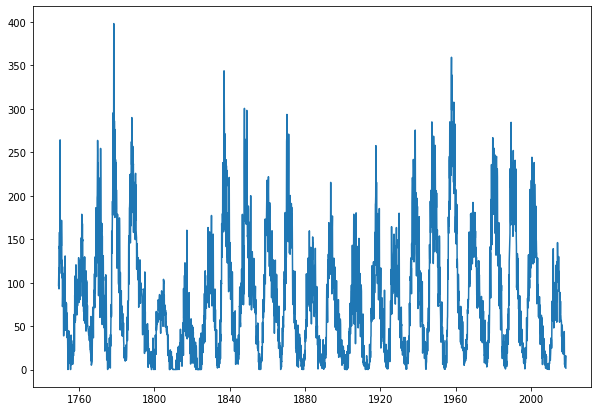

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.plot(df)
plt.show()

In [ ]:
timesteps = df.index.to_numpy()
n_sunspots = df["Monthly Mean Total Sunspot Number"].to_numpy()

In [ ]:
timesteps[:5]

array(['1749-01-31T00:00:00.000000000', '1749-02-28T00:00:00.000000000',
       '1749-03-31T00:00:00.000000000', '1749-04-30T00:00:00.000000000',
       '1749-05-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
split_size = int(0.8 * len(n_sunspots))
train_n_sunspots, train_timesteps = n_sunspots[:split_size], timesteps[:split_size]
val_n_sunspots, val_timesteps = n_sunspots[split_size:], timesteps[split_size:]

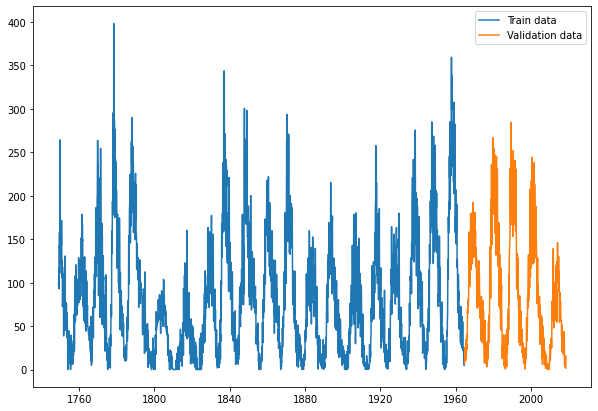

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(train_timesteps, train_n_sunspots, label="Train data")
plt.plot(val_timesteps, val_n_sunspots, label="Validation data")
plt.legend()
plt.show()

In [ ]:
n_sunspots[:5]

array([ 96.7, 104.3, 116.7,  92.8, 141.7])

In [ ]:
def get_labelled_windows(x, horizon):

  return x[:,:-horizon],x[:,-horizon:]

In [ ]:
import numpy as np

In [ ]:
def get_windows(x, window_size, horizon):

  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)),axis=0).transpose()

  windowed_array = x[window_indexes]

  windows, labels = get_labelled_windows(windowed_array,horizon)

  return windows, labels

In [ ]:
WINDOW_SIZE = 7
HORIZON = 1

full_windows, full_labels = get_windows(n_sunspots, window_size=WINDOW_SIZE, horizon=HORIZON)

In [ ]:
split_size = int(0.8 * len(full_windows))
train_windows, train_labels = full_windows[:split_size], full_labels[:split_size]
val_windows, val_labels = full_windows[split_size:], full_labels[split_size:]

In [ ]:
import tensorflow as tf

In [ ]:
expanding_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

In [ ]:
# Create the model
inputs = tf.keras.layers.Input(shape=WINDOW_SIZE)

x = expanding_layer(inputs)

x = tf.keras.layers.LSTM(128, activation="relu")(x)

x = tf.keras.layers.Dense(32, activation="relu")(x)

outputs = tf.keras.layers.Dense(HORIZON)(x)

model = tf.keras.models.Model(inputs, outputs)

model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam())

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               69632     
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 73,793
Trainable params: 73,793
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_windows, train_labels, epochs=100, validation_data=(val_windows, val_labels))

Epoch 1/100
81/81 [==============================] - 2s 7ms/step - loss: 27.2208 - val_loss: 17.6342
Epoch 2/100
81/81 [==============================] - 0s 4ms/step - loss: 18.6700 - val_loss: 17.2375
Epoch 3/100
81/81 [==============================] - 0s 4ms/step - loss: 18.7157 - val_loss: 17.5923
Epoch 4/100
81/81 [==============================] - 0s 4ms/step - loss: 18.4650 - val_loss: 17.3793
Epoch 5/100
81/81 [==============================] - 0s 4ms/step - loss: 18.6177 - val_loss: 17.8405
Epoch 6/100
81/81 [==============================] - 0s 4ms/step - loss: 18.4218 - val_loss: 18.0714
Epoch 7/100
81/81 [==============================] - 0s 4ms/step - loss: 18.1877 - val_loss: 17.7593
Epoch 8/100
81/81 [==============================] - 0s 4ms/step - loss: 18.2353 - val_loss: 17.1907
Epoch 9/100
81/81 [==============================] - 0s 5ms/step - loss: 18.1749 - val_loss: 17.4072
Epoch 10/100
81/81 [==============================] - 0s 4ms/step - loss: 18.1743 - val_los

In [ ]:
model.evaluate(val_windows, val_labels)

21/21 [==============================] - 0s 2ms/step - loss: 17.2394


17.239418029785156

In [ ]:
predictions = model.predict(val_windows)

In [ ]:
val_timesteps.shape, val_labels.shape, predictions.shape

((647,), (646, 1), (646, 1))

In [ ]:
def plot_time_series(timesteps, values, start=None, end=None, format="-", label=None):

  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  if label:
    plt.legend()


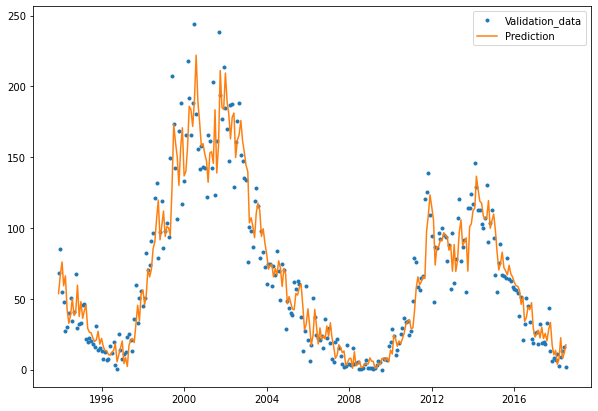

In [ ]:
plt.figure(figsize=(10,7))
plot_time_series(val_timesteps[:-1],val_labels[:,0], start=350, format=".",label="Validation_data")
plot_time_series(val_timesteps[:-1],predictions[:,0], start=350, label="Prediction")
plt.show()

In [ ]:
model.save("prediction.h5")